In [42]:
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.processes import Piecewise
from nengo.processes import WhiteSignal
from nengo.solvers import LstsqL2

In [43]:
#Dictionary for transition to and from neurons. Used in encoding and decoding process.
Morse = {
    # codes from https://www.itu.int/rec/R-REC-M.1677-1-200910-I/en
    "A": "10111",
    "B": "111010101",
    "C": "11101011101",
    "D": "1110101",
    "E": "1",
    "F": "101011101",
    "G": "111011101",
    "H": "1010101",
    "I": "101",
    "J": "1011101110111",
    "K": "111010111",
    "L": "101110101",
    "M": "1110111",
    "N": "11101",
    "O": "11101110111",
    "P": "10111011101",
    "Q": "1110111010111",
    "R": "1011101",
    "S": "10101",
    "T": "111",
    "U": "1010111",
    "V": "101010111",
    "W": "101110111",
    "X": "11101010111",
    "Y": "1110101110111",
    "Z": "11101110101",
    " ": "0",  # space
    "1": "10111011101110111",
    "2": "101011101110111",
    "3": "1010101110111",
    "4": "10101010111",
    "5": "101010101",
    "6": "11101010101",
    "7": "1110111010101",
    "8": "111011101110101",
    "9": "11101110111011101",
    "0": "1110111011101110111",
    ".": "10111010111010111",  # period
    ",": "1110111010101110111",  # comma
    ":": "11101110111010101",  # colon
    "?": "101011101110101",  # question
    "'": "1011101110111011101",  # apostrophe
    "-": "111010101010111",  # dash or minus
    "/": "1110101011101",  # slash
    "(": "111010111011101",  # left parenthesis
    ")": "1110101110111010111",  # right parenthesis
    "\"": "101110101011101",  # quote
    "=": "1110101010111",  # equals
    "+": "1011101011101",  # plus
    "@": "10111011101011101",  # at sign (@)
    # these punctuation marks are not included in the ITU recommendation,
    # but are found in https://en.wikipedia.org/wiki/Morse_code
    "!": "1110101110101110111",  # exclamation point
    "&": "10111010101",  # ampersand (also prosign for 'WAIT')
    ";": "11101011101011101",  # semicolon
    "_": "10101110111010111",  # underscore
    "$": "10101011101010111"  # dollar sign
}


In [44]:
#take user input
msg = input("Type phrase to translate here: ")
print('\n', msg)
#convert to all uppercase
msg = msg.upper()
#transform from string to an array with each character a separate element
msg = list(msg)
print('\n', msg)
my_morse = []
#evaluate each character in the list and convert to morse
for i in msg:
    my_morse.append(Morse.get(i))

print('\n', my_morse, '\n')
print(len(my_morse))


 B

 ['B']

 ['111010101'] 

1


In [45]:
#parse the list into individual 1's and 0's. 
temp_inputs = [int for string in my_morse for int in string] #got this line from Chat GPT
#add four 0's to the end of each character
for i in range(0,4):
    temp_inputs.append('0')
print(temp_inputs)

['1', '1', '1', '0', '1', '0', '1', '0', '1', '0', '0', '0', '0']


In [46]:
model = nengo.Network(label="Mercier Final Project")

send_inp = [] #1 for dot; 2 for dash
count = 0
#determine if there is a dot or dash 
for i in range(len(temp_inputs)):
    #current is a 1 and there is three 1's in a row - append a 2 (dash)
    if temp_inputs[i] == '1':
        count += 1
        if count == 3:
            send_inp.append(2)
            count = 0
    #current is a 0 and the count of 1's is 1 - append a 1 (dot)
    if temp_inputs[i] == '0' and count == 1:
        send_inp.append(1)
        count = 0
    #need to add condidtion for stringing two characters together
print(send_inp)

with model:
    #function for input node (takes array with 1,2 format)
    def input_func(array_in):
        t = [0]
        x = [0]
        for i in array_in:
            #if there is a dot, first send 0 for .33 s then a pulse (h=.5) for .33 s.
            if i == 1:
                x.append(.5)
                x.append(0)
                t.append(t[-1]+.33)
                t.append(t[-1]+.33)
            #if there is a dash, first send 0 for .33 s then a pulse for 1 s.
            elif i ==2: 
                x.append(1)
                x.append(0)
                t.append(t[-1]+.33)
                t.append(t[-1]+1)
        piecewise = Piecewise({time:value for time, value in zip(t,x)})
        return piecewise
        
    input_node = nengo.Node(input_func(send_inp))

[2, 1, 1, 1]


In [47]:
with model:
    #Create ensemble. Increase n_neurons for more accurate results.
    ensembleA = nengo.Ensemble(n_neurons=200, dimensions=1)
    #Connect the input node to ensemble.
    nengo.Connection(input_node, ensembleA)
    #Probe the node
    probe1 = nengo.Probe(input_node)
    #Probe the ensemble
    probe2 = nengo.Probe(ensembleA, synapse=.01)
    

In [48]:
#length to run simulation (must be long enough to represent each character)
sim_time = 6
with nengo.Simulator(model) as sim:
    # run for sim_time seconds
    sim.run(sim_time)

Build finished in 0:00:01.                                                      


Simulation finished in 0:00:01.                                                 


Text(0.5, 1.0, 'Neuron Input')

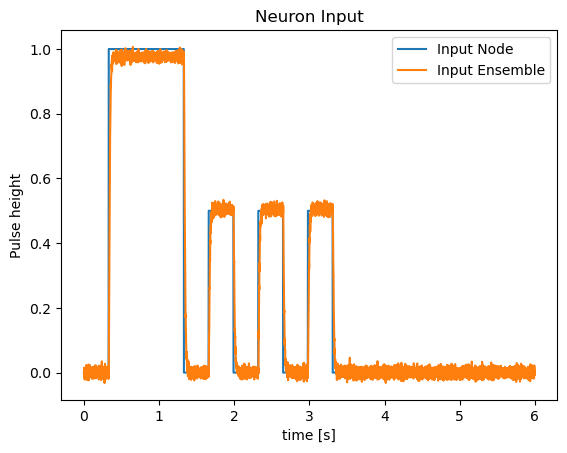

In [52]:
plt.figure()
plt.plot(sim.trange(), sim.data[probe1], label="Input Node")
plt.plot(sim.trange(), sim.data[probe2], label="Input Ensemble")
plt.legend(loc="upper right")
plt.xlabel("time [s]")
plt.ylabel("Pulse height")
plt.title("Neuron Input")